## Descriptive Statistics

In [6]:
# load statements
import pandas as pd

df = pd.read_excel('Data/all_statements.xlsx')

In [7]:
# stats
print(f'Total number of statements: {len(df)}')

mean = df.groupby('actor').size().reset_index(name='statements').statements.mean()
print(f'Average number of statements per actor: {round(mean, 2)}')



Total number of statements: 559
Average number of statements per actor: 5.95


In [8]:
# list actors by standing
df.groupby('actor').size().reset_index(name='statements').sort_values(by='statements', ascending=False).head(10)

,actor,statements
65,Stuttgarter Nachrichten (StN),67
16,CDU/CSU,53
85,Welt Online (Welt),31
35,Grüne,30
57,Rheinische Post (RP),28
8,Bundesverband Deutsche Heizungsindustrie (BDH),27
67,Süddeutsche Zeitung (SZ),25
80,Verbraucherzentrale NRW (VeZe NRW),22
75,Verband Energiehandel Südwest (VEH),17
59,SPD,17


In [9]:
# list concepts by standing
df[df.concept_cat.str.contains('Pol')].groupby('concept').size().reset_index(name='statements').sort_values(by='statements', ascending=False).head(10)

,concept,statements
0,Abwrackprämie Ölheizungen (Abwr. Öl),31
36,Verbot Ölheizungen (Verbot Öl),31
5,CO2-Bepreisung,22
16,Erneuerbare-Wärme-Gesetz (EEWärmeG),18
10,Effizienzlabel,14
20,Förderung Transparenz (Förd. Transp.),13
30,RE-Förderung,11
9,CO2-Steuer,11
25,NRE-Förderung,9
39,bessere steuerliche Förderung (st. Förderung),8


## Statements per Source and Year

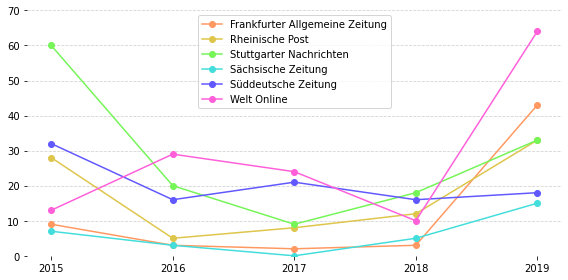

In [11]:
# number of statements per source and year
import matplotlib.pyplot as plt

d = df.groupby(['source', 'year']).size().reset_index(name='#statements').pivot(index='source', columns='year', values='#statements').fillna(0).astype(int)
l = d.values.tolist()
x = d.columns
c = ['#FF9961', '#DEC54B', '#75F558', '#43DEDC', '#6158FF', '#FF60DA']

# plot
fig = plt.figure(figsize=(8,4), frameon=False)
for i, j in zip(l,c):
    plt.plot(x, i, marker='o', c=j)
    
#plt.legend(d.index, bbox_to_anchor=(1, 0.75))
plt.legend(d.index)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.box(False)
plt.grid(which='major', axis='y', color='lightgrey', linestyle='--')
plt.ylim([0,70])
plt.tight_layout()
plt.show();
#fig.savefig('Figures/statements_per_year.png');

## Affiliation Network

In [15]:
# load statements
import pandas as pd

df = pd.read_excel('Data/all_statements.xlsx')

In [16]:
# get affiliation data
from discourse_networks import get_affiliation_dataframe

affiliation_df = get_affiliation_dataframe(df[df.concept_cat == 'Politikmaßnahme'], 
                                             concept_col='concept',
                                             abb=True, 
                                             min_degree=3)

In [17]:
# bipartite network
import networkx as nx

def get_bipartite_network(affiliation_df, largest_comp=True):

    G = nx.Graph()
    G.add_nodes_from(affiliation_df.actor.unique(), bipartite=0)
    G.add_nodes_from(affiliation_df.concept.unique(), bipartite=1)
    G.add_edges_from([tuple(x) for x in affiliation_df[['actor','concept']].to_numpy()])

    # use only largest connected component
    if largest_comp == True:
        G = G.subgraph(max(nx.connected_components(G), key=len))

    # get positions
    top = nx.bipartite.sets(G)[0]
    pos = nx.bipartite_layout(G, top)
    
    return G, pos


g, pos = get_bipartite_network(affiliation_df)

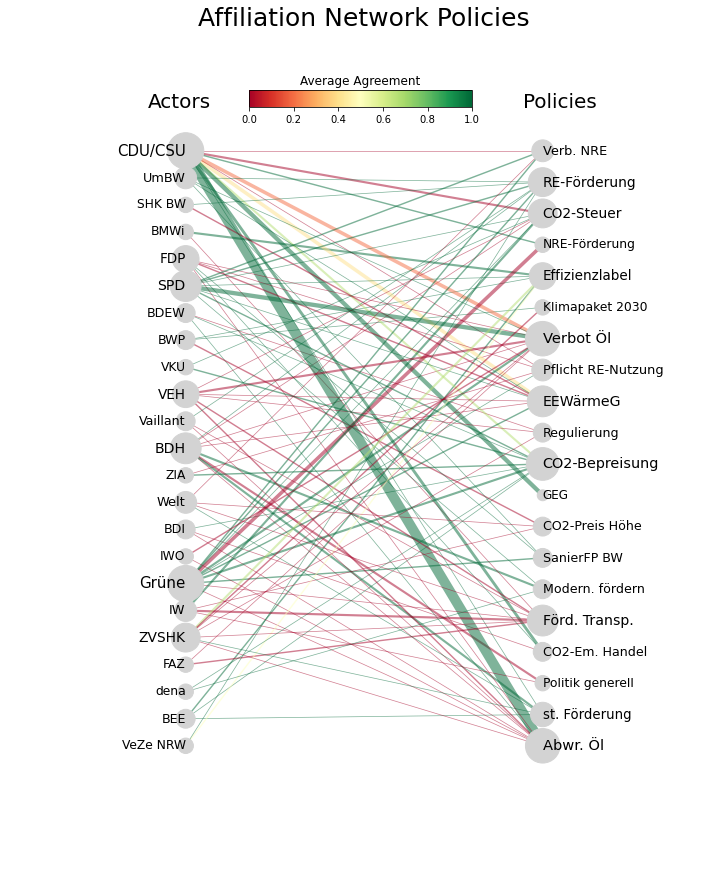

In [18]:
# plot
from matplotlib import pyplot as plt
from matplotlib import gridspec, colors
import matplotlib.cm as cm

d = nx.degree_centrality(g)
fig = plt.figure(figsize=(10,12), constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)

nodesize = 5000

ax = fig.add_subplot(gs[0,0])

# draw nodes
nx.draw_networkx_nodes(g, 
                       pos, 
                       node_color='lightgrey',
                       node_size=[v * nodesize for v in {k: d[k] for k in g.nodes}.values()]
                       )

# edge colors
minima = min(affiliation_df.agreement)
maxima = max(affiliation_df.agreement)

# normalize
norm = colors.Normalize(vmin=minima, vmax=maxima, clip=True)
mapper = cm.ScalarMappable(norm, cmap=cm.get_cmap('RdYlGn'))

edge_colors = [mapper.to_rgba(x) for x in affiliation_df.agreement]

# edge widths
width_factor = 10

edge_widths = [(float(i)/max(affiliation_df.weight))*width_factor for i in affiliation_df.weight]

# draw edges
nx.draw_networkx_edges(g, 
                       pos,
                       edge_color=edge_colors,
                       alpha = 0.5, 
                       ax=ax,
                       width=edge_widths
                       )


# print labels
def normalize(x, old, new):
    return 12 + (x - old[0]) * (new[1] - new[0]) / (old[1] - old[0])

offset_factor = 1
for key, value in pos.items():
    fontsize = normalize(d[key], (min(d.values()), max(d.values())), (12,15))
    if key in affiliation_df.actor.unique():
        plt.text(value[0], value[1], key, 
                 horizontalalignment='right',
                 verticalalignment='center',
                 fontsize=fontsize)
    else:
        plt.text(value[0], value[1], key, 
                 horizontalalignment='left',
                 verticalalignment='center',
                 fontsize=fontsize)

# add colorbar
cbaxes = fig.add_axes([0.34, 0.88, 0.31, 0.02]) 
cbar = plt.colorbar(mapper, ax=ax, cax = cbaxes, orientation='horizontal')
cbar.ax.set_title('Average Agreement')

# add axis titles
fig.text(0.2, 0.88, 'Actors', fontsize=20)
fig.text(0.72, 0.88, 'Policies', fontsize=20)

# margins & title
ax.margins(x=.5, y=.2)
ax.axis('off')
ax.set_title('Affiliation Network Policies', size=25)

plt.show()
# fig.savefig('Figures/affiliation_network.png')

## Actors - Standing

In [19]:
# load statements
import pandas as pd

df = pd.read_excel('Data/all_statements.xlsx')

In [20]:
# actor category standing
df.groupby('actor_cat').size().reset_index(name='statements').sort_values(by='statements', ascending=False)

,actor_cat,statements
10,Verband,128
6,Partei,106
13,Zeitung regional,106
12,Zeitung national,68
0,Amt,38
11,Verbraucherzentrale,33
9,Unternehmen,25
5,Institut,24
1,Energieberatung,16
7,Think Tank,6


In [21]:
# party standing
df[df.actor_cat == 'Partei'].pivot_table(index='actor', columns='year', values='title', aggfunc='count', fill_value=0)

year,2015,2016,2017,2018,2019
actor,,,,,
CDU/CSU,4,2,4,4,37
FDP,1,1,1,2,2
Grüne,4,4,2,3,17
Linke,0,0,0,0,1
SPD,4,0,2,0,11


## Actors - Coalitions

In [22]:
# load statements
import pandas as pd

df = pd.read_excel('Data/all_statements.xlsx')

### Community Detection

In [23]:
# imports
from discourse_networks import *
import networkx as nx

In [24]:
# create the matrices

# global minimum degree
min_deg = 2

# policies
pol = get_actor_concept_matrix(df[df.concept_cat == 'Politikmaßnahme'], 
                               'actor', 'concept', 'agreement', min_degree=min_deg)

# technologies
tech = get_actor_concept_matrix(df[df.concept_cat.str.contains('Tech')],
                                'actor', 'concept', 'agreement', min_degree=min_deg)

In [25]:
# create the edgelists

# policies
congruence_pol = get_network_dataframe(pol, type_='actor congruence')

# technologies
congruence_tech = get_network_dataframe(tech, type_='actor congruence')

In [26]:
# construct graphs

# policies
G_congruence_pol = nx.from_pandas_edgelist(congruence_pol, 'actor1', 'actor2', 'weight')

# technologies
G_congruence_tech = nx.from_pandas_edgelist(congruence_tech, 'actor1', 'actor2', 'weight')

In [27]:
# plot function
from cdlib import algorithms, evaluation
import matplotlib.cm as cm
import matplotlib
import matplotlib.pyplot as plt 
from matplotlib import gridspec
import networkx as nx
from matplotlib.lines import Line2D
from statistics import mean

def plot_network_communities(G, plot_pos, title=None, subtract=False, communities=False):
    
    # create axis
    ax = fig.add_subplot(plot_pos) 
    
    # node positions and degrees
    pos = nx.spring_layout(G)#, iterations=1000)#, k=0.5, scale=0.1)
    dc = nx.algorithms.centrality.degree_centrality(G)
    
    node_size_factor = 1000

    if communities == True:
        # apply algorithm
        communities = algorithms.leiden(G, weights='weight')

        # report modularity
        mod = round(evaluation.newman_girvan_modularity(G,communities).score, 2)
        print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - ')
        print('Modularity '+ title+': ', mod)

        #### community measures

        # scaled_density: The scaled density of a community is defined as the 
        # ratio of the community density w.r.t. the complete graph density.

        # internal_edge_density:
        mod_dens = evaluation.scaled_density(G,communities, summary=False)
        mod_dens = evaluation.internal_edge_density(G,communities, summary=False)
        
      

        #### color the nodes according to their partition
        d = communities.to_node_community_map()

        # flatten lists
        for k, v in d.items():
            d[k] = mean(v)

        # get number of communities
        no_coms = max(d.values())

        # list of colors
        color_palette = ['cornflowerblue', 'lightcoral', 'mediumseagreen', 'orange']

        # color communities
        colors = []
        density_dict = {}
        for i, color in zip(range(no_coms), color_palette):
            colors.append(color)
            density_dict[color] = round(mod_dens[i], 2)

        print('\nInternal Edge Densities:')
        print(density_dict)
        
        # custom legend
        legend_elements = []
        for k, v in density_dict.items():
            elem = Line2D([0], [0], marker='o', color=k, label=v, markersize=12)
            legend_elements.append(elem)

        ax.legend(handles=legend_elements, loc='best', title='Density')
        plt.rcParams['legend.title_fontsize'] = 'medium'     

        # create colormap
        node_list = d.keys()
        node_colors = list(d.values())
        node_sizes = [dc[node] * node_size_factor for node in d.keys()]
        cmap = matplotlib.colors.ListedColormap(colors)
    
    else: 
        node_list = G.nodes()
        node_colors = 'lightgrey'
        node_sizes = [dc[node] * node_size_factor for node in G.nodes()]
        cmap = None
  
    #### plot network
    
    # draw nodes   
    nx.draw_networkx_nodes(G, 
                           pos,
                           nodelist=node_list, 
                           cmap=cmap, 
                           alpha=0.5,
                           node_color=node_colors, 
                           ax=ax, 
                           node_size=node_sizes
                           )

    
    # draw edges
    edge_width_factor = 3
    edge_widths = [edge[2].get('weight') * edge_width_factor for edge in G.edges(data=True)]
    
    if subtract == True:
        edge_colors = ['r' if edge[2].get('weight') < 0 else 'g' for edge in G.edges(data=True)]
    else:
        edge_colors = 'grey'
    
    nx.draw_networkx_edges(G, pos, alpha=0.4, ax=ax, width=edge_widths, edge_color=edge_colors)

    # draw labels
    nx.draw_networkx_labels(G, pos, verticalalignment='center', font_size=10)
    
    ax.margins(x=.1, y=.1)
    ax.axis('off')

unable to import 'smart_open.gcs', disabling that module


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Modularity policies:  0.23

Internal Edge Densities:
{'cornflowerblue': 0.21, 'lightcoral': 0.2, 'mediumseagreen': 0.2}
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
Modularity tech:  0.16

Internal Edge Densities:
{'cornflowerblue': 0.22, 'lightcoral': 0.17}


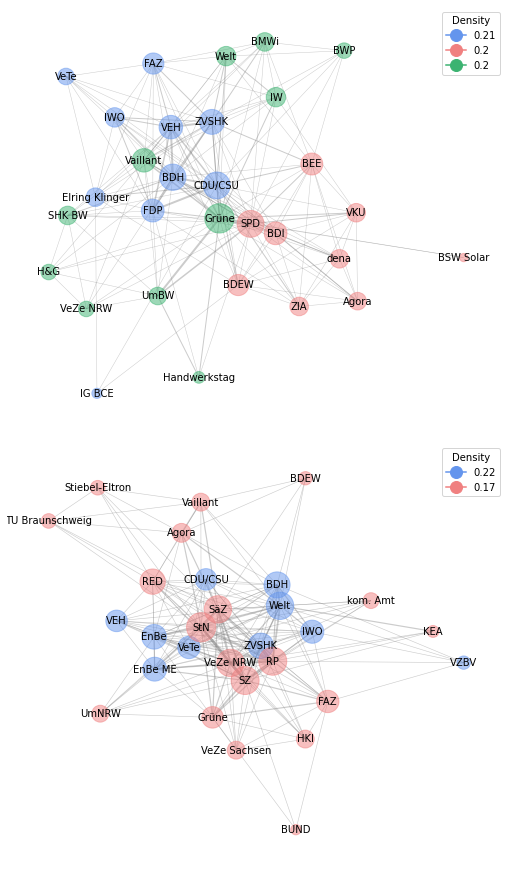

In [28]:
# plot

# init figure
fig = plt.figure(figsize=(7,12), constrained_layout=True)
gs = gridspec.GridSpec(2, 1, figure=fig)   

# plot networks
plot_network_communities(G_congruence_pol, gs[0,0], 'policies', communities=True)
plot_network_communities(G_congruence_tech, gs[1,0], 'tech', communities=True)

plt.show()

### Subtract Network

In [29]:
# imports
from discourse_networks import *
import networkx as nx

In [30]:
# load statements
import pandas as pd

df = pd.read_excel('Data/all_statements.xlsx')

In [31]:
# get graph

# get matrix
matrix = get_actor_concept_matrix(df, min_degree=5)

# get network data
subtract_nw = get_network_dataframe(matrix, type_='actor subtract')

# construct graph
G_subtract = nx.from_pandas_edgelist(subtract_nw, 'actor1', 'actor2', 'weight')

In [32]:
# get non-normalized edge weights
edge_weights = get_network_dataframe(matrix, type_='actor subtract', normalize=False)
negative_weights = edge_weights.sort_values(by='weight').head(5)
positive_weights = edge_weights.sort_values(by='weight').tail(5)
negative_weights.append(positive_weights)

print(f'Edge weight sum: {sum(edge_weights.weight)}')

Edge weight sum: 230


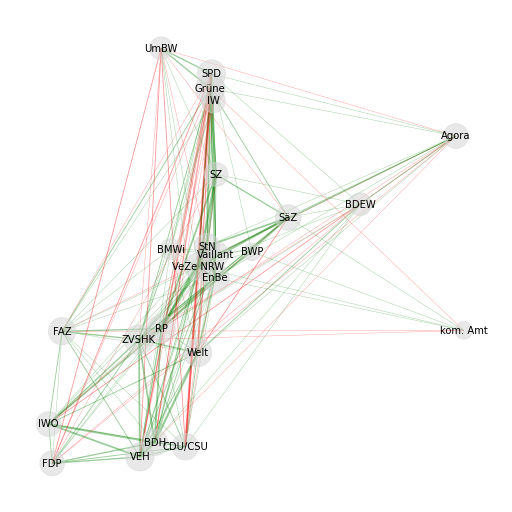

In [33]:
# plot
import matplotlib.pyplot as plt
from matplotlib import gridspec

# init figure
fig = plt.figure(figsize=(7,7), constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)   

# plot - please run cell from COMMUNITY DETECTION to init function
plot_network_communities(G_subtract, gs[0,0], subtract=True)

plt.show()

# Concepts

## Concepts - Sentiment

In [34]:
# load statements
import pandas as pd

df = pd.read_excel('Data/all_statements.xlsx')

In [35]:
# get salient concepts function

def get_salient_concepts(df, concept_col, agreement_col, actor_col, min_deg):
    concepts = df.pivot_table(index=concept_col, columns=agreement_col, values=actor_col, fill_value=0, aggfunc='count')
    concepts['total'] = concepts.iloc[:, 0] + concepts.iloc[:, 1]
    concepts = concepts[concepts.total > min_deg]
    return concepts.sort_values(by='total', ascending=True)

In [36]:
# get salient concepts
policy_statements = df[df.concept_cat == 'Politikmaßnahme']
tech_statements = df[df.concept_cat.str.contains('Tech')]

pol = get_salient_concepts(policy_statements, 'concept', 'agreement', 'actor', min_deg=5)
tech = get_salient_concepts(tech_statements, 'concept', 'agreement', 'actor', min_deg=2)

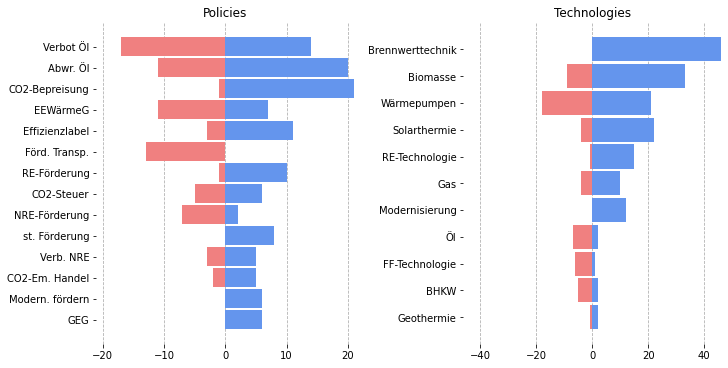

In [37]:
# plot salient concepts

from util import abbreviations

fig = plt.figure(figsize=(10,5), constrained_layout=True)
gs = gridspec.GridSpec(1, 2, figure=fig)

def plot_concept_sentiment(concepts, gs, title):
    x = range(len(concepts))

    ax = fig.add_subplot(gs)
    
    # plot values
    negative = concepts[0] * (-1)
    positive = concepts[1]

    ax.barh(x, negative, height=0.9, color='lightcoral')
    ax.barh(x, positive, height=0.9, color='cornflowerblue')
    
    # gridlines
    ax.xaxis.grid(True, linestyle='--')
    ax.set_axisbelow(True)
    
    # plot spines
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # set x limits
    m = max(list(negative) + list(positive), key=abs)
    ax.set_xlim([-m,m])
    
    # labels
    tick_labels = abbreviations(concepts.index)   
    plt.yticks(range(0,len(tick_labels)), tick_labels)
    
    plt.title(title)


plot_concept_sentiment(pol, gs[0,0], title='Policies')
plot_concept_sentiment(tech, gs[0,1], title='Technologies')

#fig.savefig('Figures/salient_concepts.svg')

## Concepts - Technology Framing

In [38]:
# load statements
df = pd.read_excel('Data/all_statements.xlsx')

In [39]:
# translate
def english_rename(cat):
    if cat == 'Umwelt':
        return 'Environment'
    if cat == 'Effizienz':
        return 'Efficiency'
    if cat == 'Kosten':
        return 'Cost'
    if cat == 'Branche':
        return 'Industry'
    if cat == 'Andere':
        return 'Other'
    
df['framing'] = df.framing.apply(english_rename)

df.concept_cat = df.concept_cat.replace('RE-Technologie', 'RET')
df.concept_cat = df.concept_cat.replace('FF-Technologie', 'FFT')

In [42]:
# get data
tech = df[df.concept_cat.str.contains('RET|FFT')]
pos = tech[tech.agreement == 1].pivot_table(index='concept_cat',  columns='framing', 
                                            values='title', aggfunc='count', fill_value=0)
neg = tech[tech.agreement == 0].pivot_table(index='concept_cat',  columns='framing', 
                                            values='title', aggfunc='count', fill_value=0)

neg = neg * (-1)
combo = pd.concat([pos, neg], axis=1)

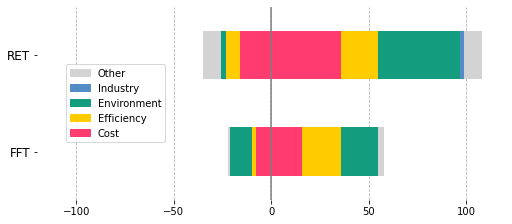

In [43]:
# plot re vs. nre framing
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(7,3), constrained_layout=True)
gs = gridspec.GridSpec(1, 1, figure=fig)
ax = fig.add_subplot(gs[0,0])

color_dict = {'Efficiency': '#ffcc00', 'Cost': '#ff3b6f', 'Environment': '#149C7E', 
              'Industry': '#538cc6', 'Other': 'lightgrey', 'No framing': 'black'}

combo.plot(kind='barh', color=[color_dict[x] for x in combo.columns], stacked=True, ax=ax, legend=True)

# legend
handle_list = []
for c in reversed(pos.columns):
    handle_list.append(mpatches.Patch(color=color_dict[c], label=c))

plt.legend(handles=handle_list, loc='center left', bbox_to_anchor=(0.05, 0.5));

# set x limits
ax.set_xlim([-120,120])

# tick marks
ax.tick_params(axis='y', which='major', labelsize=12)

# gridlines
ax.xaxis.grid(True, linestyle='--')
ax.set_axisbelow(True)

# plot spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# seperation line
plt.axvline(x=0, color='grey')

plt.ylabel(None);

fig.savefig('Figures/tech_framing.svg')

## Concept - Factor Analysis

In [44]:
# imports
import pandas as pd
from util import *

In [45]:
# load statements
df = pd.read_excel('Data/all_statements.xlsx')

In [46]:
# get matrices
from discourse_networks import get_actor_concept_matrix

matrix_pol = get_actor_concept_matrix(df[df.concept_cat.str.contains('Pol')], min_degree=2)
matrix_tech = get_actor_concept_matrix(df[df.concept_cat.str.contains('Tech')], min_degree=2)

In [47]:
# fit PCA
from sklearn.decomposition import PCA

pca_pol = PCA(n_components=1)
pca_tech = PCA(n_components=1)

fit_pol = pca_pol.fit_transform(matrix_pol)
components_pol = pca_pol.components_

fit_tech = pca_tech.fit_transform(matrix_tech)
components_tech = pca_tech.components_

In [48]:
# metrics

# eigenvalue: pca.explained_variance_
# explained variance: pca.explained_variance_ratio_

eigen_pol = pca_pol.explained_variance_
expl_v_pol = pca_pol.explained_variance_ratio_
print('Eigenvalue Policies PC: {}'.format(eigen_pol))
print('Explained Variance Policies PC: {}'.format(expl_v_pol))

eigen_tech = pca_tech.explained_variance_
expl_v_tech = pca_tech.explained_variance_ratio_
print('\nEigenvalue Tech PC: {}'.format(eigen_tech))
print('Explained Variance Tech PC: {}'.format(expl_v_tech))

Eigenvalue Policies PC: [0.96827293]
Explained Variance Policies PC: [0.27484419]

Eigenvalue Tech PC: [0.69138952]
Explained Variance Tech PC: [0.27764999]


In [49]:
# get factor loadings

# list of pca values
values_pol = list(components_pol.T.flatten())
values_tech = list(components_tech.T.flatten())

# normalize and round (reverse policy values for better interpretability)
values_pol = [-x for x in values_pol]
values_pol = ['%.2f' % elem for elem in norm(-1,1,values_pol)]
values_tech = ['%.2f' % elem for elem in norm(-1,1,values_tech)]

# create dfs
components_pol_df = pd.DataFrame({'Policy': matrix_pol.columns.tolist(), 'PC1': values_pol})
components_tech_df = pd.DataFrame({'Technology': matrix_tech.columns.tolist(), 'PC1': values_tech})

# limit to top ten
top_concepts_pol = df[(df.concept_cat == 'Politikmaßnahme')].groupby('concept').size().sort_values(ascending=False).head(10).index.tolist()
top_concepts_tech = df[(df.concept_cat.str.contains('Tech'))].groupby('concept').size().sort_values(ascending=False).head(10).index.tolist()

# use abbr
top_concepts_pol = abbreviations(top_concepts_pol)
top_concepts_tech = abbreviations(top_concepts_tech)


top_components_pol_df = components_pol_df[components_pol_df.Policy.isin(top_concepts_pol)]
top_components_pol_df.PC1 = top_components_pol_df.PC1.astype(float)
top_components_pol_df.sort_values(by='PC1')

top_components_tech_df = components_tech_df[components_tech_df.Technology.isin(top_concepts_tech)]
top_components_tech_df.PC1 = top_components_tech_df.PC1.astype(float)
top_components_tech_df.sort_values(by='PC1')

,Technology,PC1
1,Biomasse,-1.00
9,Solarthermie,-0.63
8,RE-Technologie,-0.55
10,Wärmepumpen,-0.37
0,BHKW,-0.19
7,Modernisierung,0.29
3,Brennwerttechnik,0.36
4,FF-Technologie,0.38
11,Öl,0.77
5,Gas,1.00


In [50]:
# create dfs and merge, normalized, reverse policy
fit_pol_norm = norm(-1,1,fit_pol.flatten())
fit_pol_norm = [-x for x in fit_pol_norm]
fit_tech_norm = norm(-1,1,fit_tech.flatten())
fit_tech_norm = [-x for x in fit_tech_norm]

df_pol = pd.DataFrame({'actor': matrix_pol.index, 'pc_policy':fit_pol_norm})
df_tech = pd.DataFrame({'actor': matrix_tech.index, 'pc_tech':fit_tech_norm})
merge = df_pol.merge(df_tech, on='actor', how='inner')

In [51]:
# correlation
from scipy.stats import pearsonr

print('Correlation and p-value')
pearsonr(merge.pc_policy, merge.pc_tech)

Correlation and p-value


(-0.43617554253860774, 0.1362202073177939)

In [52]:
# get standing of each actor
df['actor_abbreviations'] = abbreviations(df.actor)
def get_standing(actor): 
    return len(df[df.actor_abbreviations == actor])
    
merge['standing'] = merge.actor.apply(get_standing)

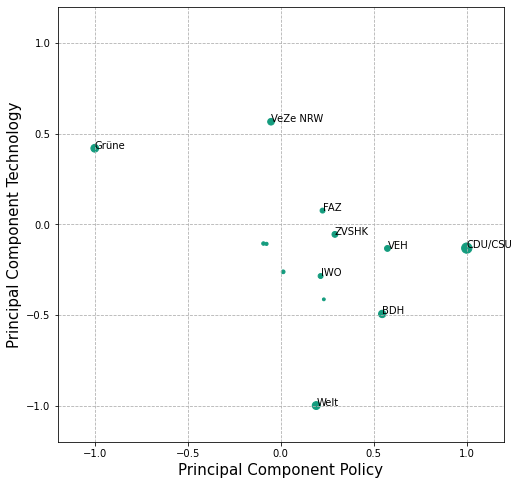

In [53]:
# plot pcs
from adjustText import adjust_text
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8,8))

ax = fig.add_subplot(1,1,1) 

ax.set_xlabel('Principal Component Policy', fontsize = 15)
ax.set_ylabel('Principal Component Technology', fontsize = 15)

#### marker size according to standing

# get standing dictionary

size_factor = 2
sizes = []
for standing in merge.standing:
    sizes.append(standing*size_factor)
#sizes = norm(10,100,sizes)

# plot
ax.scatter(merge.pc_policy, merge.pc_tech, s=sizes, c='#149C7E')

# only label busy actors
top_actors = merge[merge.standing > 10].actor
top_actors = abbreviations(top_actors)

for i, actor in enumerate(merge.actor):
    if actor in top_actors:
        ax.annotate(actor, (merge.pc_policy.iloc[i], merge.pc_tech.iloc[i]))
        

# grid
ax.grid(which='major', axis='both', linestyle='dashed', markevery=0.5)
ax.set_ylim([-1.2,1.2])
ax.set_xlim([-1.2,1.2])
    
fig.savefig('Figures/pca_plot.svg')

# Discourse over Time

## Framing over Time - Shares

In [54]:
# load statements
import pandas as pd

df = pd.read_excel('Data/all_statements.xlsx')

In [55]:
# translate
def english_rename(cat):
    if cat == 'Umwelt':
        return 'Environment'
    if cat == 'Effizienz':
        return 'Efficiency'
    if cat == 'Kosten':
        return 'Cost'
    if cat == 'Branche':
        return 'Industry'
    if cat == 'Andere':
        return 'Other'
    
df['framing'] = df.framing.apply(english_rename)

In [56]:
# framing over time table
from util import abs2rel

df.loc[df.framing.isnull(), 'framing'] = 'No framing'
table = df.pivot_table(index='year', columns='framing', values='title', aggfunc='count')
abs2rel(table)

framing,Cost,Efficiency,Environment,Industry,No framing,Other
year,,,,,,
2015,35.57,18.12,18.79,6.71,12.08,8.72
2016,28.95,18.42,27.63,3.95,15.79,5.26
2017,14.06,10.94,26.56,1.56,25.00,21.88
2018,25.00,17.19,23.44,3.12,21.88,9.38
2019,12.62,7.77,35.44,5.83,25.24,13.11


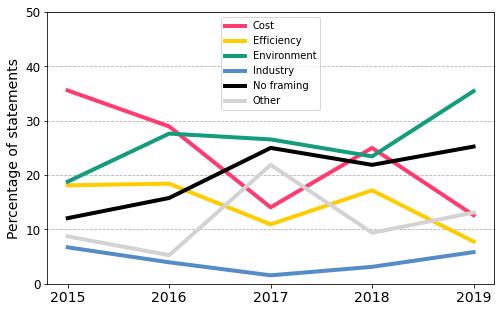

In [57]:
# plot
import matplotlib.pyplot as plt


color_dict = {'Efficiency': '#ffcc00', 'Cost': '#ff3b6f', 'Environment': '#149C7E', 
              'Industry': '#538cc6', 'Other': 'lightgrey', 'No framing': 'black'}

fig = plt.figure(figsize=(8,5))

table = abs2rel(table)

for framing in table.columns:
    plt.plot(table[framing], color=color_dict[framing], linewidth=4, label=framing)
    
plt.grid(axis='y', linestyle='dashed')
plt.xticks(np.arange(min(table.index), max(table.index)+1, 1), size=14)
plt.yticks(size=12)

plt.ylabel('Percentage of statements', size=14)
plt.ylim([0,50])

plt.legend(loc='upper center')
plt.show()

fig.savefig('Figures/framing_per_year.svg')

## Framing over Time - Popularity

In [58]:
# load statements & concat object & framing
import pandas as pd
df = pd.read_excel('Data/all_statements.xlsx')

# translate
def english_rename(cat):
    if cat == 'Umwelt':
        return 'Environment'
    if cat == 'Effizienz':
        return 'Efficiency'
    if cat == 'Kosten':
        return 'Cost'
    if cat == 'Branche':
        return 'Industry'
    if cat == 'Andere':
        return 'Other'
    
df['framing'] = df.framing.apply(english_rename)
df.loc[df.framing.isnull(), 'framing'] = 'No_Framing'
df['concept_framing'] = df.concept + ' [' + df.framing + ']'

In [59]:
# relative degree centrality per category function
def degree_centrality_categories(g):
    d = nx.algorithms.centrality.degree_centrality(g)

    rdc = {}

    for k, v in d.items():
        cat = k[k.find('[')+1:k.find(']')]
        rdc[cat] = rdc.get(cat, 0) + v/sum(d.values())

    out = pd.DataFrame([rdc]).T
    out.columns = ([', '.join(map(str, year_list))])
    return out

In [60]:
# split by year
from discourse_networks import *
import networkx as nx

year_lists = [[2015,2016,2017,2018],[2019]]
min_degree = 2

graphs = []
centralities = []
dfs = []

for year_list in year_lists:
    
    # subset
    df_year = df[df.year.isin(year_list)].reset_index(drop=True)
    dfs.append(df_year)

    # matrix
    matrix_year = get_actor_concept_matrix(df_year, concept_col='concept_framing', min_degree=min_degree, abb=False)

    # edgelist
    edgelist_year = get_network_dataframe(matrix_year, type_='concept congruence')

    # graph
    g_year = nx.from_pandas_edgelist(edgelist_year, 'concept1', 'concept2', edge_attr=True)
    graphs.append(g_year)
    
    centralities.append(degree_centrality_categories(g_year))

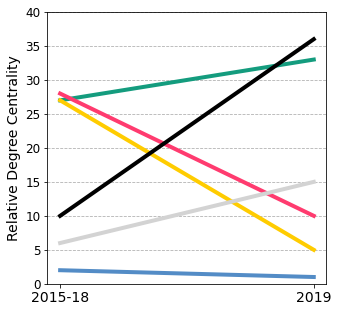

In [61]:
# plot relative degree centralities per year
import matplotlib.pyplot as plt

color_dict = {'Efficiency': '#ffcc00', 'Cost': '#ff3b6f', 'Environment': '#149C7E', 
              'Industry': '#538cc6', 'Other': 'lightgrey', 'No_Framing': 'black'}

table = centralities[0].join(centralities[1:]).fillna(0).round(2).T
table = table[['Environment', 'Cost', 'Efficiency', 'Industry', 'Other', 'No_Framing']]
table = table * 100
table.index = (['2015-18', '2019'])

fig = plt.figure(figsize=(5,5))

for framing in table.columns:
    plt.plot(table[framing], color=color_dict[framing], linewidth=4, label=framing)
    
plt.grid(axis='y', linestyle='dashed')
plt.xticks(table.index, size=14)
plt.yticks(size=12)

plt.ylabel('Relative Degree Centrality', size=14)
plt.ylim([0,40])

# plt.legend(bbox_to_anchor=(1,0.75), fontsize=12)
plt.show()

fig.savefig('Figures/relative_framing_per_year.svg')

### Table

In [66]:
# load statements & translate framing
import pandas as pd
df = pd.read_excel('Data/all_statements.xlsx')

# translate
def english_rename(cat):
    if cat == 'Umwelt':
        return 'Environment'
    if cat == 'Effizienz':
        return 'Efficiency'
    if cat == 'Kosten':
        return 'Cost'
    if cat == 'Branche':
        return 'Industry'
    if cat == 'Andere':
        return 'Other'
    
df['framing'] = df.framing.apply(english_rename)
df.loc[df.framing.isnull(), 'framing'] = 'No_Framing'

In [67]:
# environment share function
def get_env_shares(index_name, years_list, min_degree=10):
    
    # pivot
    env = df[df.year.isin(years_list)].pivot_table(index=index_name, columns='framing', values='title', aggfunc='count', fill_value=0)
    
    # threshold
    env = env[env.sum(axis=1) > min_degree]

    # subset
    env = abs2rel(env)[['Environment']]

    return env

In [68]:
# get shares for actor cateogries
column = 'actor_cat'

# get env shares actor categories
actor_cat_env_15_18 = get_env_shares('actor_cat', [2015,2016,2017,2018], min_degree=1)
actor_cat_env_19 = get_env_shares('actor_cat', [2019], min_degree=1)

# join
actor_cat_env = actor_cat_env_15_18.join(actor_cat_env_19, how='inner', lsuffix='_15-18', rsuffix='_19').fillna(0)
actor_cat_env['net'] = actor_cat_env['Environment_19'] - actor_cat_env['Environment_15-18']


# get env shares concept categories
concept_cat_env_15_18 = get_env_shares('concept_cat', [2015,2016,2017,2018])
concept_cat_env_19 = get_env_shares('concept_cat', [2019])

# join
concept_cat_env = concept_cat_env_15_18.join(concept_cat_env_19, how='inner', lsuffix='_15-18', rsuffix='_19').fillna(0)
concept_cat_env['net'] = concept_cat_env['Environment_19'] - concept_cat_env['Environment_15-18']

# append
env_15_19 = actor_cat_env.append(actor_cat_env)
env_15_19

framing,Environment_15-18,Environment_19,net
actor_cat,,,
Amt,11.54,58.33,46.79
Energieberatung,23.08,33.33,10.25
Institut,35.29,57.14,21.85
Partei,21.05,32.35,11.30
Unternehmen,18.18,35.71,17.53
Verband,22.67,22.64,-0.03
Verbraucherzentrale,12.50,33.33,20.83
Zeitung national,22.00,50.00,28.00
Zeitung regional,30.34,47.06,16.72


## National News Comparison

In [69]:
# load statements
df = pd.read_excel('Data/all_statements.xlsx')

### Framing Shares

In [70]:
# get framing shares
abs2rel(df.pivot_table(index='source', columns='framing', values='title', aggfunc='count', fill_value=0))

framing,Andere,Branche,Effizienz,Kosten,Umwelt
source,,,,,
Frankfurter Allgemeine Zeitung,12.50,20.83,6.25,14.58,45.83
Rheinische Post,9.59,1.37,21.92,32.88,34.25
Stuttgarter Nachrichten,13.45,3.36,15.97,31.09,36.13
Sächsische Zeitung,15.38,0.00,26.92,42.31,15.38
Süddeutsche Zeitung,12.16,9.46,18.92,31.08,28.38
Welt Online,20.56,5.61,14.95,22.43,36.45


### Ego Subtract Networks

In [71]:
# imports
from discourse_networks import *
import networkx as nx

In [72]:
# get graphs

# create the matrices
sources = ['Frankfurter Allgemeine Zeitung (FAZ)', 'Welt Online (Welt)', 'Süddeutsche Zeitung (SZ)']

# global minimum degree
min_deg = 2
graphs = []
networks = []

# subset dataframe
sub = df[df.actor_cat.isin(['Verband', 'Partei', 'Zeitung national'])]

matrix = get_actor_concept_matrix(sub, 'actor', 'concept', 'agreement', min_degree=min_deg)
subtract = get_network_dataframe(matrix, type_='actor subtract')

# rename weight so its not used by networkx for plotting
subtract.rename(columns={'weight':'Weight'}, inplace=True)

for abb in abbreviations(sources):
    
    # keep only news as actor
    network = subtract[(subtract.actor1 == abb) | (subtract.actor2 == abb)]
    networks.append(network)
    graphs.append(nx.from_pandas_edgelist(network, 'actor1', 'actor2', 'Weight'))

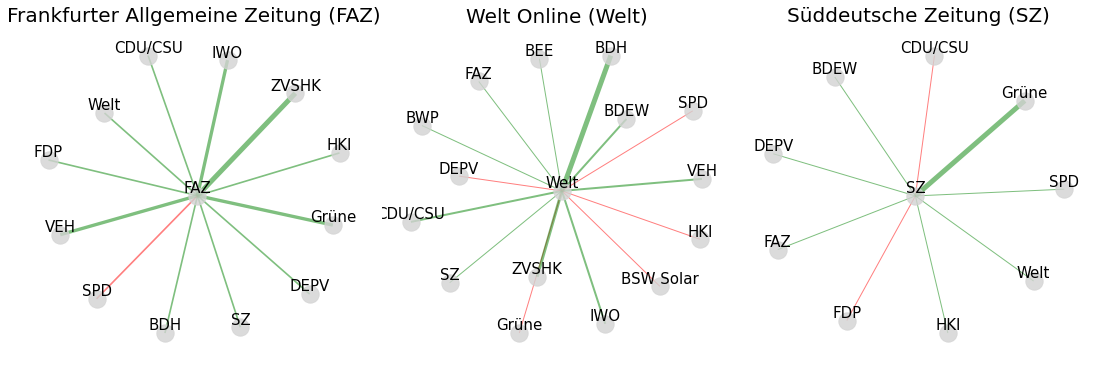

In [73]:
# plot subtract networks

import matplotlib.pyplot as plt
from matplotlib import gridspec

fig = plt.figure(figsize=(15,5), constrained_layout=True)
gs = gridspec.GridSpec(1, 3, figure=fig)
node_size = 300
title_fontsize = 20
edge_width_factor = 5

def plot_subtract_network(G, edgeframe, plot_pos, center=None, title='Title'):
    
    # create axis
    ax = fig.add_subplot(plot_pos)
    
    # get layout positions
    pos = nx.spring_layout(G)
    
    # draw nodes
    nx.draw_networkx_nodes(G, pos, alpha=0.8, node_color='lightgrey', node_size=node_size) 
    
    # draw edges
    edge_widths = [(float(i)/max(edgeframe.Weight))*edge_width_factor for i in edgeframe.Weight]
    edge_colors = ['r' if x < 0 else 'g' for x in edgeframe.Weight]

    nx.draw_networkx_edges(G, pos, alpha=0.5, ax=ax, width=edge_widths, edge_color=edge_colors)

    # draw labels
    nx.draw_networkx_labels(G, pos, verticalalignment='bottom', font_size=15)

    ax.margins(x=.1, y=.1)
    ax.set_title(title, fontsize=title_fontsize)
    ax.axis('off')
    
for i, (graph, network, source) in enumerate(zip(graphs, networks, sources)):
    plot_subtract_network(graph, network, gs[0,i], title=source)
    
fig.savefig('Figures/ego_networks_sources.svg')

### Factor Loading Scores

In [74]:
# prep

# PCA components: run cells below Concept - Factor Analysis first
components_pol_df.columns = (['concept', 'pca'])
components_tech_df.columns = (['concept', 'pca'])
factor_loadings = pd.concat([components_pol_df, components_tech_df]).reset_index(drop=True)

# get dict
pca_dict = {}
for i, row in factor_loadings.iterrows():
    pca_dict[row.concept] = float(row.pca) * (-1)

# source list
sources = ['Frankfurter Allgemeine Zeitung', 'Welt Online', 'Süddeutsche Zeitung']

In [75]:
# get score for each source
for source in sources:
    
    # get actor-concept matrix and rename index
    matrix = get_actor_concept_matrix(df[df.source==source], min_degree=2)
    matrix.index = ([source for x in range(len(matrix))])

    # get pca-loadings vector
    pca_vector = []
    for concept in matrix.columns:
        pca_vector.append(pca_dict.get(concept,0))
        
    # get sum of concept content multiplied by pca vector
    out = sum(np.array(norm(0,1,matrix.sum(axis=0))) * pca_vector)
    print(source, out)

Frankfurter Allgemeine Zeitung -0.9339999999999999
Welt Online -2.8777777777777773
Süddeutsche Zeitung 0.1757142857142857


## National vs. Regional News

In [76]:
# load statements
df = pd.read_excel('Data/all_statements.xlsx')

In [77]:
# unique actors

# no duplicates per article
# df = df.drop_duplicates(['actor', 'concept', 'framing', 'title'])

group = df.groupby('source').agg({'actor': pd.Series.nunique, 'sequence': 'count'})
group['rate'] = (group.actor / group.sequence).round(2)
group

,actor,sequence,rate
source,,,
Frankfurter Allgemeine Zeitung,22,60,0.37
Rheinische Post,18,86,0.21
Stuttgarter Nachrichten,27,140,0.19
Sächsische Zeitung,11,30,0.37
Süddeutsche Zeitung,40,103,0.39
Welt Online,33,140,0.24


In [78]:
# dummy variable
national = ['Welt Online', 'Süddeutsche Zeitung', 'Frankfurter Allgemeine Zeitung']
# regional = ['Sächsische Zeitung', 'Süddeutsche Zeitung', 'Rheinische Post']

def news_type(source):
    if source in national:
        return 'national'
    else:
        return 'regional'

df['type'] = df.source.apply(news_type)

In [79]:
# compare national and regional
group = df.groupby('type').agg({'actor': pd.Series.nunique, 'sequence': 'count'})
group['rate'] = (group.actor / group.sequence).round(2)
group

,actor,sequence,rate
type,,,
national,67,303,0.22
regional,44,256,0.17


In [80]:
# newspaper type: own statement rate among all their published statements
sub = df[((df.type == 'national') & (df.actor_cat == 'Zeitung national')) | 
           ((df.type == 'regional') & (df.actor_cat == 'Zeitung regional'))].groupby('actor').size().reset_index(name='own_statements')

join = df.groupby('source').size().reset_index(name='all_statements').join(sub).drop('actor', axis=1)

join['rate'] = join.own_statements / join.all_statements
join

,source,all_statements,own_statements,rate
0,Frankfurter Allgemeine Zeitung,60,12,0.200000
1,Rheinische Post,86,28,0.325581
2,Stuttgarter Nachrichten,140,67,0.478571
3,Sächsische Zeitung,30,11,0.366667
4,Süddeutsche Zeitung,103,25,0.242718
5,Welt Online,140,31,0.221429


In [81]:
# dialogue measurement: balanced concept coverage

print('---Explanation---')
print('No of statements | balanced rate')
print('Policies')
print('Technologies')
print('Both')

for source in df.source.unique(): 
    
    print('- - - - - - - - - - - - - - - -')
    print(source)
    
    balanced_concepts_pol = 0
    balanced_concepts_tech = 0
    balanced_concepts_sub = 0    

    pol = df[(df.source==source) & (df.concept_cat.str.contains('Pol'))]
    tech = df[(df.source==source) & (df.concept_cat.str.contains('Tech'))]
    sub = df[(df.source==source)]
    
    for concept in pol.concept.unique():
        if len(pol[pol.concept==concept].groupby(['concept', 'agreement']).size().reset_index()) == 2:
            balanced_concepts_pol += 1
    
    print(len(pol.concept.unique()), balanced_concepts_pol/len(pol.concept.unique()))
    
    for concept in tech.concept.unique():
        if len(tech[tech.concept==concept].groupby(['concept', 'agreement']).size().reset_index()) == 2:
            balanced_concepts_tech += 1
    
    print(len(tech.concept.unique()),balanced_concepts_tech/len(tech.concept.unique()))
    
    for concept in sub.concept.unique():
        if len(sub[sub.concept==concept].groupby(['concept', 'agreement']).size().reset_index()) == 2:
            balanced_concepts_sub += 1
    
    print(len(sub.concept.unique()),balanced_concepts_sub/len(sub.concept.unique()))

---Explanation---
No of statements | balanced rate
Policies
Technologies
Both
- - - - - - - - - - - - - - - -
Welt Online
24 0.20833333333333334
11 0.2727272727272727
39 0.23076923076923078
- - - - - - - - - - - - - - - -
Süddeutsche Zeitung
22 0.2727272727272727
10 0.4
40 0.275
- - - - - - - - - - - - - - - -
Rheinische Post
8 0.25
8 0.25
20 0.25
- - - - - - - - - - - - - - - -
Sächsische Zeitung
4 0.25
8 0.25
16 0.1875
- - - - - - - - - - - - - - - -
Stuttgarter Nachrichten
19 0.21052631578947367
10 0.5
37 0.24324324324324326
- - - - - - - - - - - - - - - -
Frankfurter Allgemeine Zeitung
14 0.2857142857142857
4 0.25
21 0.23809523809523808


In [82]:
# negativity
abs2rel(df.pivot_table(index='source', columns='agreement', values='title', aggfunc='count'))

agreement,0,1
source,,
Frankfurter Allgemeine Zeitung,48.33,51.67
Rheinische Post,9.30,90.70
Stuttgarter Nachrichten,22.14,77.86
Sächsische Zeitung,33.33,66.67
Süddeutsche Zeitung,33.98,66.02
Welt Online,43.57,56.43


### Actor Category Plot

In [83]:
# import statements
df = pd.read_excel('Data/all_statements.xlsx')

In [84]:
# dummy variable
national = ['Welt Online', 'Süddeutsche Zeitung', 'Frankfurter Allgemeine Zeitung']
# regional = ['Sächsische Zeitung', 'Süddeutsche Zeitung', 'Rheinische Post']

def national_vs_regional(source):
    if source in national:
        return 'national'
    else:
        return 'regional'
df['type'] = df.source.apply(national_vs_regional)

In [85]:
# remove newspaper's own statements
df = df[~((df.actor_cat == 'Zeitung national') | 
          (df.actor_cat == 'Zeitung regional'))]

In [86]:
# recode actor_cat
cat = ['Verband', 'Partei', 'Unternehmen', 'Amt']

def recode_cat(actor_cat):
    if actor_cat in cat:
        return actor_cat
    if actor_cat in ['Verbraucherzentrale', 'Energieberatung']:
        return 'Beratung'
    else:
        return 'other'
    
df['actor_cat_plot'] = df.actor_cat.apply(recode_cat)

In [87]:
# rename newspapers
def rename_source(source):
    if source == 'Frankfurter Allgemeine Zeitung':
        return 'FAZ'
    if source == 'Welt Online':
        return 'WELT'
    if source == 'Süddeutsche Zeitung':
        return 'SZ'
    if source == 'Sächsische Zeitung':
        return 'SäZ'
    if source == 'Stuttgarter Nachrichten':
        return 'StN'
    if source == 'Rheinische Post':
        return 'RP'
    
df['source'] = df.source.apply(rename_source)

In [88]:
# translate
# recode actor_cat

def translate_cat(actor_cat):
    if actor_cat == 'Verband':
        return 'Association'
    if actor_cat == 'Amt':
        return 'Administration'
    if actor_cat == 'Unternehmen':
        return 'Company'
    if actor_cat == 'Partei':
        return 'Party'
    if actor_cat == 'Verbraucherzentrale':
        return 'Consumer Centre'
    else:
        return 'Other'
    
df['actor_cat_plot'] = df.actor_cat.apply(translate_cat)

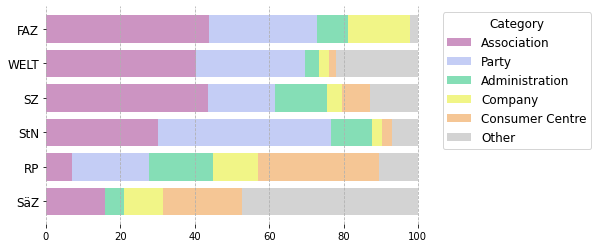

In [89]:
# plot
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.colors
from util import abs2rel

# pivot df
pivot = df.pivot_table(index='source', columns='actor_cat_plot', values='title', fill_value=0, aggfunc='count')

# reorder
pivot = pivot[['Association', 'Party', 'Administration', 'Company', 'Consumer Centre', 'Other']]
pivot = pivot.reindex(reversed(['FAZ', 'WELT', 'SZ', 'StN', 'RP', 'SäZ']))

# relative numbers
pivot = abs2rel(pivot)

# set colormap
# https://color.adobe.com/create/color-wheel
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#CC94C2','#C4CDF5','#85DEB6',
                                                               '#F1F587','#F5C695','lightgrey'])

fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot()

pivot.plot(kind='barh', width=0.8, stacked=True, figsize=(7, 4), colormap=cmap, ax=ax)
#ax.set_xlabel('Percentage')
ax.set_ylabel(None)
ax.tick_params(axis='y', which='major', labelsize=12)

legend = plt.legend(title='Category', bbox_to_anchor=(1.0, 1), loc='upper left', prop={'size': 12})
plt.setp(legend.get_title(),fontsize='large')

# plot spines
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(which='major', axis='x', linestyle='dashed')

plt.show()
fig.savefig('Figures/actor_category_source_comparison.svg', bbox_inches='tight')